In [1]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
!pip freeze > requirements_local.txt

In [84]:
!pip install eli5

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.4 MB/s eta 0:00:00
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [85]:
import os
import time
import random
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import lightgbm as lgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import phik
from phik.report import plot_correlation_matrix
from phik import report
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from PM_eq import penman_monteith
from process_fluxes import create_rolling_windows

# Data Preprocessing

In [99]:
mod = np.load('./data_v02/MOD_features_all.npy', allow_pickle=True)
mod_idxs = set(np.load('./data_v02/MOD_target_idx_all.npy', allow_pickle=True))
era5 = np.load('./data_v02/ERA5_features.npy', allow_pickle=True)
era5_idxs = set(np.load('./data_v02/ERA5_target_idx.npy', allow_pickle=True))

fluxes = pd.read_csv('./data_v02/target_fluxes_MidWest_LE.csv')
fluxes = fluxes[fluxes['LE_F_MDS_QC']>=0.75]
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in era5_idxs) and (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y%m%d')
targets = fluxes.LE_F_MDS.values

fluxes

,TIMESTAMP,LE_F_MDS,LE_F_MDS_QC,NETRAD,G_F_MDS,TA_F,VPD_F,WS_F,PA_F,site,H_F_MDS,lat,lon,IGBP
0,2003-05-24,19.2224,1.0000,236.108854,-1.567770,11.213,10.345,1.841,98.421,FLX_US-Wi1,138.470000,46.7305,-91.2329,DBF
1,2003-05-25,24.2024,1.0000,227.120214,-1.126670,12.308,10.551,1.835,98.471,FLX_US-Wi1,112.405000,46.7305,-91.2329,DBF
2,2003-05-26,19.4017,0.9375,249.112486,0.019932,14.778,12.203,1.660,98.656,FLX_US-Wi1,108.937000,46.7305,-91.2329,DBF
3,2003-05-27,23.7468,1.0000,244.104535,1.914990,18.154,15.802,1.532,98.265,FLX_US-Wi1,112.939000,46.7305,-91.2329,DBF
4,2003-05-28,42.2603,0.9375,246.821474,0.114018,14.890,6.921,2.285,97.722,FLX_US-Wi1,85.043500,46.7305,-91.2329,DBF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155271,2003-09-11,55.7628,1.0000,126.808894,7.353920,23.534,10.864,2.743,96.827,AMF_US-Wi3,15.796000,46.6347,-91.0987,DBF
155272,2003-09-13,31.6040,1.0000,65.703064,-8.120460,15.390,2.544,1.353,96.572,AMF_US-Wi3,-8.821360,46.6347,-91.0987,DBF
155273,2003-09-14,54.2463,1.0000,92.268000,-8.471200,13.966,4.375,1.341,96.912,AMF_US-Wi3,-10.596500,46.6347,-91.0987,DBF
155274,2003-09-15,44.2428,1.0000,99.622415,-3.575530,12.401,3.585,1.304,96.968,AMF_US-Wi3,-0.490375,46.6347,-91.0987,DBF


In [100]:
era5_idxs = pd.Series(list(era5_idxs))
era5_idxs.index = np.arange(len(era5_idxs))
valid_feature_indices = era5_idxs[era5_idxs.isin(fluxes.index)].index.values
era5_features = era5[valid_feature_indices]

mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

NDVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0])
EVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + 6*mod_features[:,:,0] - 7.5*mod_features[:,:,2] + 1)
GNDVI = (mod_features[:,:,1] - mod_features[:,:,3])/(mod_features[:,:,1] + mod_features[:,:,3])
SAVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0] + 0.5)*1.5
ARVI = (mod_features[:,:,1] + mod_features[:,:,2] - 2*mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,2] + 2*mod_features[:,:,0])

#pm_flux = penman_monteith(fluxes, fluxes.index, fluxes, mode='ground').values / 10
pm_era = penman_monteith(era5_features, fluxes.index, fluxes, mode='era5')

features = np.concatenate([era5_features, mod_features,
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

era_names = list(np.loadtxt('./data_v02/ERA5_features_names.txt', dtype=str))
mod_names = [
          'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
         'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
         'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 
]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [58]:
df = pd.DataFrame(data=features[:,-1,:], columns=mod_names+['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI'])


In [59]:
cols = [x for x in df.columns if not x.endswith('_ewm')]
for idx, col in enumerate(cols):
    if col in ['surface_net_solar_radiation_sum','total_evaporation_sum','total_precipitation_sum',]:
      ewm = pd.DataFrame(features[:,:,idx]).T.rolling(window=30).sum().iloc[[-1]].values
      df[col+'_rol_30'] = ewm.T
      ewm_7 = pd.DataFrame(features[:,:,idx]).T.rolling(window=7).sum().iloc[[-1]].values
      df[col+'_rol_7'] = ewm_7.T
    else:
      ewm = pd.DataFrame(features[:,:,idx]).T.rolling(window=30, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_30'] = ewm.T
      ewm_7 = pd.DataFrame(features[:,:,idx]).T.rolling(window=7, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_7'] = ewm_7.T
    Min = pd.DataFrame(features[:,:,idx]).T.min(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_min'] = Min
    Max = pd.DataFrame(features[:,:,idx]).T.max(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_max'] = Max
    std = pd.DataFrame(features[:,:,idx]).T.std(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_std'] = std
df

,SensorZenith,SensorAzimuth,SolarZenith,SolarAzimuth,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,...,SAVI_rol_30,SAVI_rol_7,SAVI_min,SAVI_max,SAVI_std,ARVI_rol_30,ARVI_rol_7,ARVI_min,ARVI_max,ARVI_std
0,-7688.0,1044.0,15649.0,2755.0,671.0,2220.0,348.0,599.0,2830.0,2571.0,...,-2.812059,-3.402160,-10.580120,-0.341583,2.971624,2.932151,5.971087,-44.711864,27.949356,11.366360
1,-6919.0,5713.0,17835.0,2577.0,518.0,2279.0,295.0,618.0,2445.0,1658.0,...,-3.080630,-4.136137,-15.717959,-0.341583,3.699831,2.905350,5.918134,-44.711864,27.949356,11.363106
2,10194.0,989.0,15036.0,2817.0,674.0,2564.0,359.0,674.0,3134.0,2707.0,...,-3.094565,-4.169035,-15.717959,-0.341583,3.691789,2.903013,5.913157,-44.711864,27.949356,11.363742
3,-7178.0,4828.0,17167.0,2561.0,476.0,2446.0,271.0,582.0,2694.0,1866.0,...,-3.205182,-4.447361,-15.717959,-0.341583,3.779275,2.855912,5.816337,-44.711864,27.949356,11.352651
4,9959.0,2853.0,14450.0,2902.0,810.0,3333.0,663.0,948.0,3752.0,2555.0,...,-3.214104,-4.468402,-15.717959,-0.341583,3.773136,2.853934,5.812325,-44.711864,27.949356,11.353173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100086,-7574.0,2845.0,16756.0,4274.0,1366.0,3380.0,1644.0,1607.0,3195.0,1710.0,...,-3.881847,-3.305702,-16.478413,-0.407683,4.500915,3.391581,2.035396,-4.139233,21.158958,5.145233
100087,-7990.0,1027.0,16365.0,4397.0,9251.0,9480.0,8743.0,9128.0,8548.0,6065.0,...,-3.372298,-3.377655,-16.269280,-0.407683,3.847659,4.053568,5.828223,-4.139233,23.634561,6.333234
100088,-6951.0,5714.0,17920.0,4327.0,4859.0,5737.0,4881.0,4962.0,5472.0,3626.0,...,-3.623933,-4.077157,-16.269280,-0.407683,4.360848,4.022291,5.774212,-4.139233,23.634561,6.331761
100089,10348.0,1008.0,15990.0,4533.0,1313.0,3813.0,1185.0,1429.0,3804.0,2267.0,...,-3.637381,-4.110781,-16.269280,-0.407683,4.352550,4.021106,5.769007,-4.139233,23.634561,6.332555


In [60]:
df['doy'] = fluxes['TIMESTAMP'].reset_index(drop=True).dt.dayofyear
df['lat'] = fluxes.lat.values
df['lon'] = fluxes.lon.values
df['IGBP'] = fluxes.IGBP.values
df['IGBP'] = df['IGBP'].astype('category')
df['t2m'] = fluxes.TA_F.values
df['sp'] = fluxes.PA_F.values
df['netrad'] = fluxes.NETRAD.values
df['ground_flux'] = fluxes.G_F_MDS.values
df['sense_heat'] = fluxes.H_F_MDS.values
df['vpd'] = fluxes.VPD_F.values
df['wind'] = fluxes.WS_F.values
df['LE_PM'] = pm_flux
df['LE'] = fluxes.LE_F_MDS.values
df

,SensorZenith,SensorAzimuth,SolarZenith,SolarAzimuth,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,...,IGBP,t2m,sp,netrad,ground_flux,sense_heat,vpd,wind,LE_PM,LE
0,-7688.0,1044.0,15649.0,2755.0,671.0,2220.0,348.0,599.0,2830.0,2571.0,...,DBF,11.213,98.421,236.108854,-1.567770,138.470000,10.345,1.841,114.917723,19.2224
1,-6919.0,5713.0,17835.0,2577.0,518.0,2279.0,295.0,618.0,2445.0,1658.0,...,DBF,12.308,98.471,227.120214,-1.126670,112.405000,10.551,1.835,114.531888,24.2024
2,10194.0,989.0,15036.0,2817.0,674.0,2564.0,359.0,674.0,3134.0,2707.0,...,DBF,14.778,98.656,249.112486,0.019932,108.937000,12.203,1.660,136.640895,19.4017
3,-7178.0,4828.0,17167.0,2561.0,476.0,2446.0,271.0,582.0,2694.0,1866.0,...,DBF,18.154,98.265,244.104535,1.914990,112.939000,15.802,1.532,148.639450,23.7468
4,9959.0,2853.0,14450.0,2902.0,810.0,3333.0,663.0,948.0,3752.0,2555.0,...,DBF,14.890,97.722,246.821474,0.114018,85.043500,6.921,2.285,125.731223,42.2603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100086,-7574.0,2845.0,16756.0,4274.0,1366.0,3380.0,1644.0,1607.0,3195.0,1710.0,...,DBF,23.534,96.827,126.808894,7.353920,15.796000,10.864,2.743,78.096864,55.7628
100087,-7990.0,1027.0,16365.0,4397.0,9251.0,9480.0,8743.0,9128.0,8548.0,6065.0,...,DBF,15.390,96.572,65.703064,-8.120460,-8.821360,2.544,1.353,42.346747,31.6040
100088,-6951.0,5714.0,17920.0,4327.0,4859.0,5737.0,4881.0,4962.0,5472.0,3626.0,...,DBF,13.966,96.912,92.268000,-8.471200,-10.596500,4.375,1.341,55.944989,54.2463
100089,10348.0,1008.0,15990.0,4533.0,1313.0,3813.0,1185.0,1429.0,3804.0,2267.0,...,DBF,12.401,96.968,99.622415,-3.575530,-0.490375,3.585,1.304,54.598720,44.2428


In [61]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

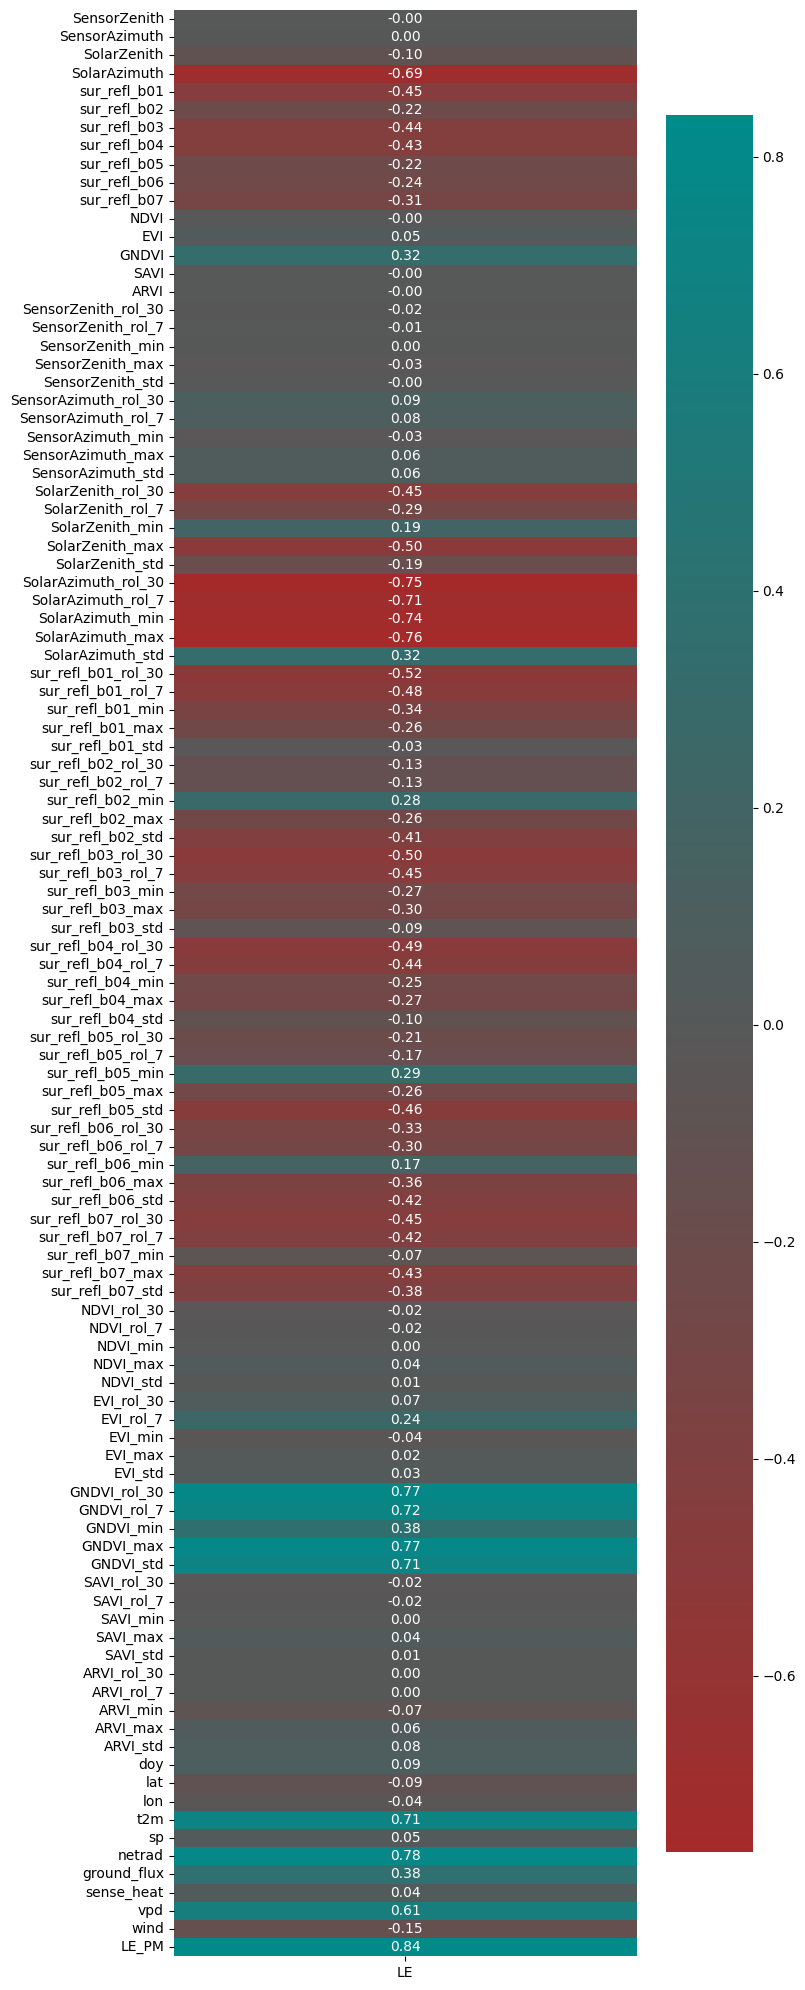

In [68]:
correlation_matrix = df.drop('IGBP', axis=1).corr()[["LE"]].iloc[:-1]

plt.figure(figsize=(8, 20))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
#plt.savefig('./fig/targets_heatmap_ground.png')
plt.show()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

# LightGBM

### LOGS:
**Stratified by IGBP:**

R2: 0.987	RMSE: 4.577	MAE: 1.26

In [72]:
train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.08, #0.15
    'num_leaves': 100,
    'verbose': -1,
    #'device': 'gpu'
}

lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=5000)
y_pred_lgb = lgbm.predict(X_test)
print(f'R2: {round(r2_score(y_test, y_pred_lgb),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred_lgb)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred_lgb)**0.5,3)}')

R2: 0.987	RMSE: 4.577	MAE: 1.26


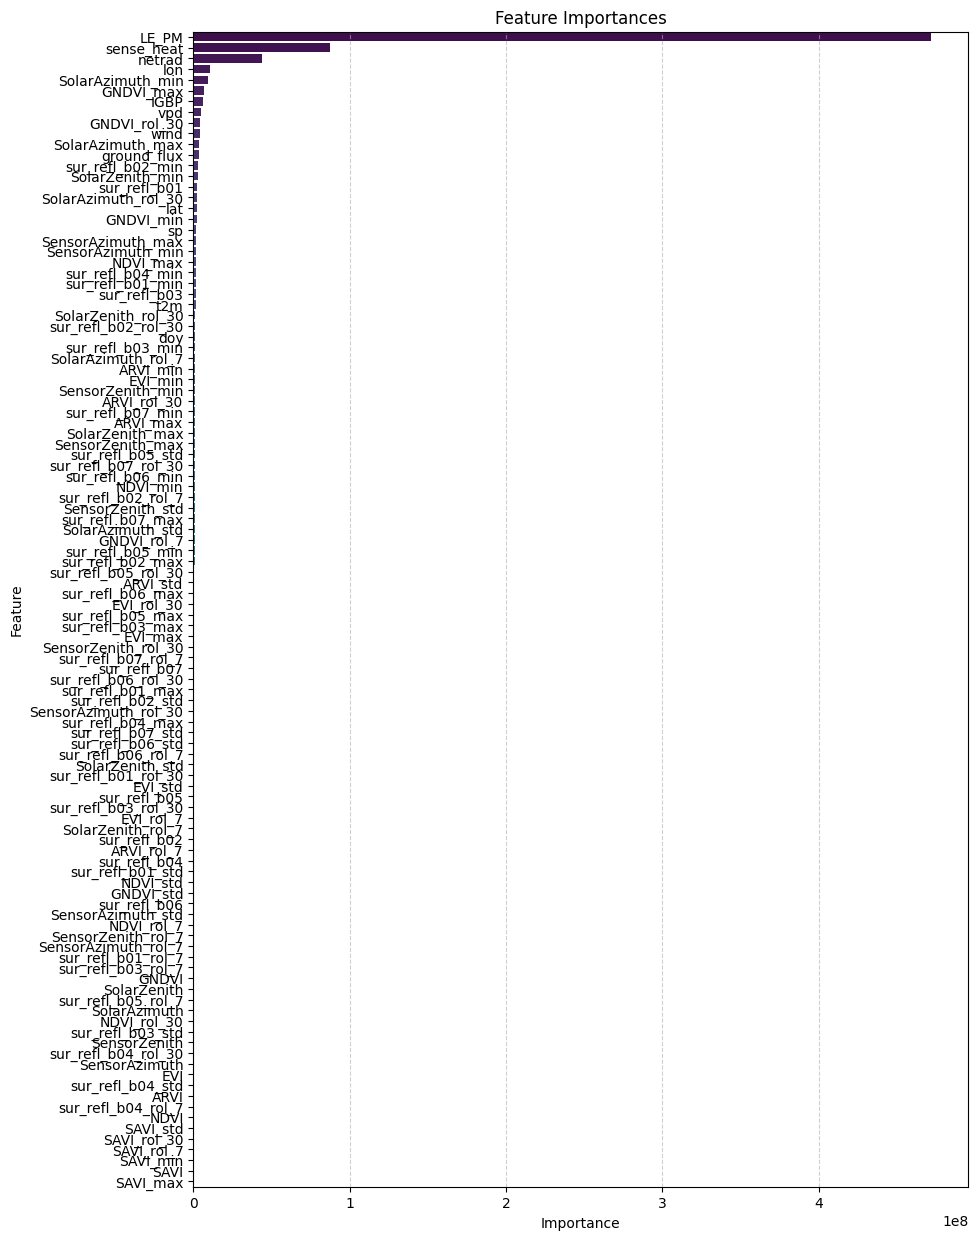

In [65]:
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importance(importance_type='gain')  # or 'split'
})

fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Random Forest

R2: 0.97	RMSE: 7.002	MAE: 2.04

In [80]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_rf, X_test_rf = X_train.copy(), X_test.copy()
X_train_rf['IGBP'] = encoder.fit_transform(X_train[['IGBP']])
X_test_rf['IGBP'] = encoder.transform(X_test[['IGBP']])

In [81]:
rf = RandomForestRegressor(max_depth=18, random_state=123, n_estimators=500, n_jobs=-1)
rf.fit(X_train_rf, y_train)
y_pred_rf = rf.predict(X_test_rf)
print(f'R2: {round(r2_score(y_test, y_pred_rf),3)}\tRMSE: {round(mean_squared_error(y_test, y_pred_rf)**0.5,3)}\tMAE: {round(mean_absolute_error(y_test, y_pred_rf)**0.5,3)}')

R2: 0.97	RMSE: 7.002	MAE: 2.04


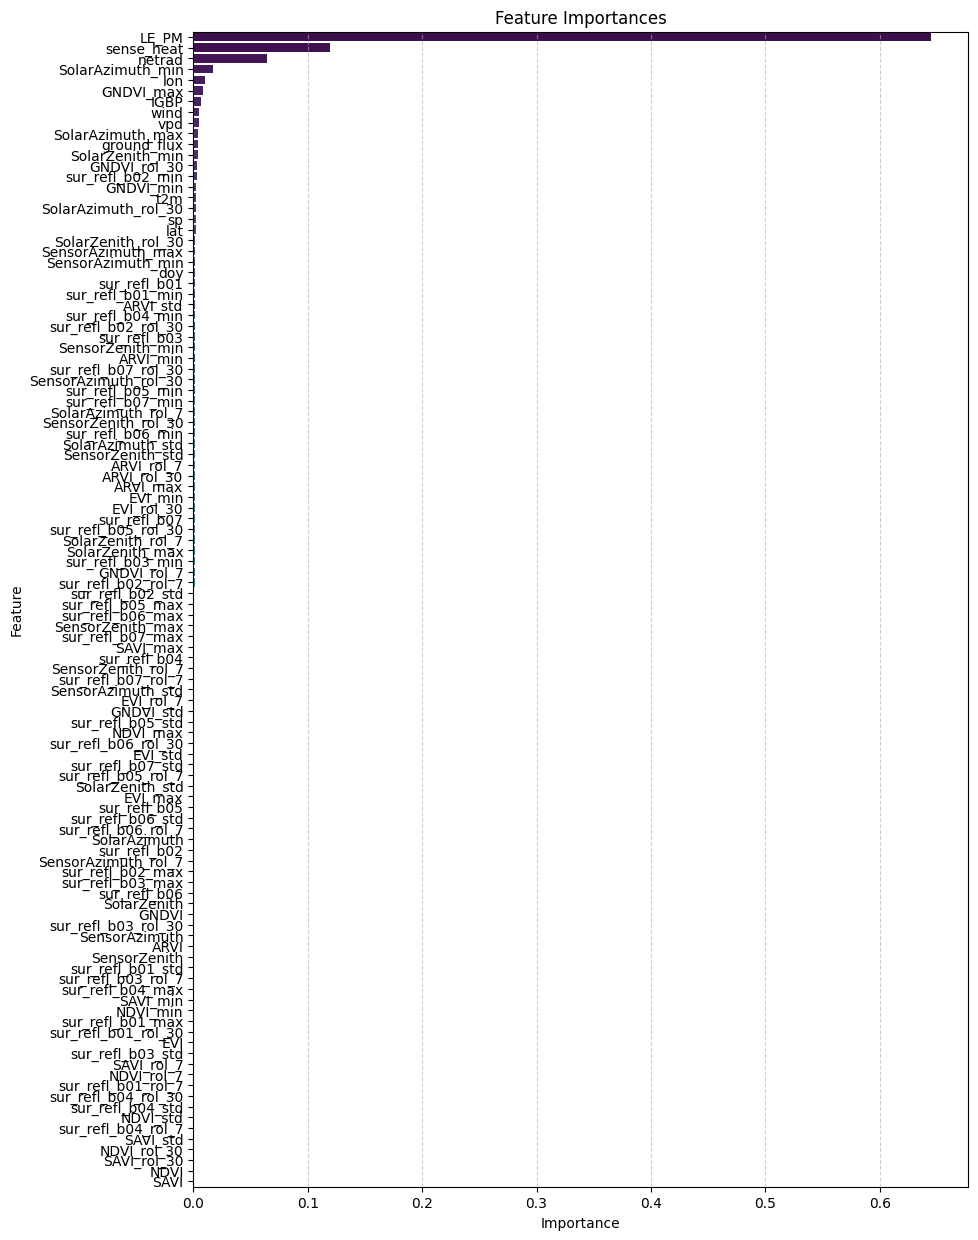

In [83]:
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# ANN

In [89]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.Tanh()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.Tanh())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [91]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [92]:
one_hot = pd.get_dummies(X_train.IGBP)
X_train_ann = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
one_hot = pd.get_dummies(X_test.IGBP)
X_test_ann = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)

In [93]:
BATCH_SIZE = 512
device = ('cuda' if torch.cuda.is_available() else 'cpu')
num_epoch = 1000
feature_num = X_test_ann.values.shape[1]
n1 = 400
n2 = 100
dropout=0.3

In [94]:
model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)

In [95]:
train_dataset = Dataset(X_train_ann, y_train.values, fit_scaler=True)
x_scaler = train_dataset.x_scaler 
y_scaler = train_dataset.y_scaler 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
test_loader = DataLoader(Dataset(X_test_ann.values, y_test.values,
                                 x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)

In [96]:
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.5e-2) 

In [97]:
best = -np.inf
t0 = time.time()
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, y in train_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        pred = model(x)
        error = criteria(pred, y)

        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        test_preds = []
        test_true = []
        test_x = []
        test_idx = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(torch.float32), y.to(torch.float32)
                preds = model(x)
                preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
                y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
                test_preds.append(torch.tensor(preds))
                test_true.append(torch.tensor(y_scaled))

        test_preds = torch.cat(test_preds).squeeze()
        test_true = torch.cat(test_true).squeeze()
        
        test_loss = criteria(test_preds, test_true).item()
        r2 = r2_score(test_true.numpy(), test_preds.numpy())
        mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
        #writer.add_scalar("Loss/test", test_loss, epoch)
        #writer.add_scalar("R2/test", r2, epoch)
        
        best_old = best
        best = min(test_loss, best)
        if abs(best) > best_old:
            torch.save(model.state_dict(), f'./models/ANN.pth') #0.6532
            #writer.add_text("Checkpoint", "Saved model at epoch {}".format(epoch))
        print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')
#writer.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Test RMSE: 22.516		Test R2: 0.6861		 Test MAE: 17.0731
Test RMSE: 15.914		Test R2: 0.8432		 Test MAE: 11.2311
Test RMSE: 17.940		Test R2: 0.8007		 Test MAE: 14.2038
Test RMSE: 15.600		Test R2: 0.8493		 Test MAE: 11.1730
Test RMSE: 14.949		Test R2: 0.8616		 Test MAE: 10.3908
Test RMSE: 15.114		Test R2: 0.8586		 Test MAE: 10.4401
Test RMSE: 16.352		Test R2: 0.8345		 Test MAE: 12.0854
Test RMSE: 14.605		Test R2: 0.8679		 Test MAE: 10.0509
Test RMSE: 14.059		Test R2: 0.8776		 Test MAE: 9.5599
Test RMSE: 13.901		Test R2: 0.8804		 Test MAE: 9.3666
Test RMSE: 14.110		Test R2: 0.8767		 Test MAE: 9.8396
Test RMSE: 15.001		Test R2: 0.8607		 Test MAE: 10.8662
Test RMSE: 14.248		Test R2: 0.8743		 Test MAE: 9.9135
Test RMSE: 13.475		Test R2: 0.8876		 Test MAE: 9.1021
Test RMSE: 13.269		Test R2: 0.8910		 Test MAE: 8.9045
Test RMSE: 12.984		Test R2: 0.8956		 Test MAE: 8.6074
Test RMSE: 12.813		Test R2: 0.8984		 Test MAE: 8.6807
Test RMSE: 12.853		Test R2: 0.8977		 Test MAE: 8.7242
Test RMSE: 13.613		

KeyboardInterrupt: 